## Задание Pro



1. Выберите 10 самых красивых по вашем мнению пятерок в тренировочной выборке mnist.
2. Создайте датасет, где объекты – это все пятерки из тренировочной части mnist, а метки – это случайные пятерки из "красивого" набора.
3. Создайте автокодировщик и проверьте, совпадают ли у него размеры выхода и входа.
4. Обучите автокодировщик.
5. Добейтесь ошибки MSE на тренировочной выборке **<0.05**.
6. Посмотрите, как выглядят пятерки из тестовой выборки после обученного автокодировщика.

## Импорт библиотек

In [2]:
# Для операций с тензорами
import numpy as np

# Для отрисвоки
import matplotlib.pyplot as plt

# Для создания модели
from tensorflow.keras.models import Model

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Слои для латентного пространства модели
from tensorflow.keras.layers import Flatten, Reshape, Dense

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Для загрузки базы
from tensorflow.keras.datasets import mnist

E0000 00:00:1748125674.365438    1738 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748125674.388621    1738 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Загрузка данных

In [3]:
# Загрузка датасета
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Нормализация данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [5]:
# Приведение формы к удобной для Keras
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [6]:
# Отбор пятерок
mask = y_train == 5
X_train = X_train[mask]
y_train = y_train[mask]

In [7]:
# Аналогично для тестирования
mask = y_test == 5
X_test = X_test[mask]
y_test = y_test[mask]

## Отбор красивых пятерок

In [ ]:
# Ваше решение
def plot_images(x_data, pred, n=5):
    plt.figure(figsize=(14, 7))

    for i in range(1, n + 1):
        index = np.random.randint(0, pred.shape[0])

        ax = plt.subplot(2, n, i)
       
        plt.imshow(x_data[index].squeeze(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 1:
            ax.set_title("Оригинал")


        ax = plt.subplot(2, n, i + n)
        plt.imshow(pred[index].squeeze(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 1:
            ax.set_title("Реконструкция")

    plt.show()

In [9]:
print(f"Количество пятерок в тренировочной выборке: {X_train.shape[0]}")
print(f"Количество пятерок в тестовой выборке: {X_test.shape[0]}")

Количество пятерок в тренировочной выборке: 5421
Количество пятерок в тестовой выборке: 892


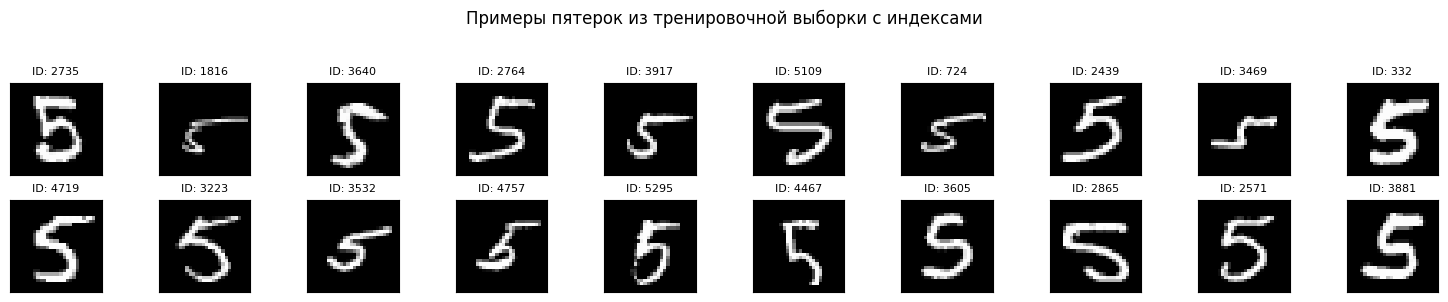

In [ ]:
num_to_display = 20
ncols = 10
nrows = (num_to_display + ncols - 1) // ncols

plt.figure(figsize=(ncols * 1.5, nrows * 1.5))
plt.suptitle(
    "Примеры пятерок из тренировочной выборки с индексами",
    y=1.02,
)

for i, image_idx in enumerate(np.random.choice(X_train.shape[0], size=num_to_display, replace=False)):
    ax = plt.subplot(nrows, ncols, i + 1)
    plt.imshow(X_train[image_idx].squeeze(), cmap="gray")
    ax.set_title(f"ID: {image_idx}", fontsize=8)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


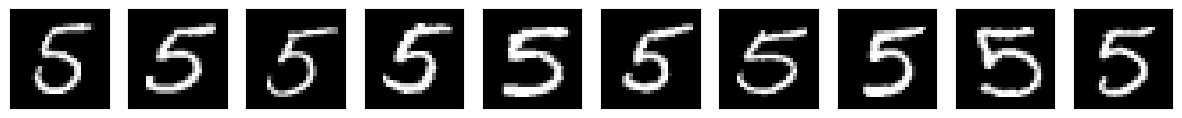

In [ ]:
selected_beautiful_fives_indices = [
    67,
    1280,
    1983,
    5326,
    1894,
    758,
    3190,
    3698,
    4173,
    2571,
]
beautiful_fives = X_train[selected_beautiful_fives_indices]

num_beautiful_fives = len(beautiful_fives)
plt.figure(figsize=(num_beautiful_fives * 1.5, 2))
for i in range(num_beautiful_fives):
    ax = plt.subplot(1, num_beautiful_fives, i + 1)
    plt.imshow(beautiful_fives[i].squeeze(), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [64]:
X_train_input = X_train
X_train_target = np.empty_like(X_train)

for i in range(X_train.shape[0]):
    random_beautiful_index = np.random.randint(0, num_beautiful_fives)
    X_train_target[i] = beautiful_fives[random_beautiful_index]

print(f"Размерность входного датасета: {X_train_input.shape}")
print(f"Размерность целевого датасета: {X_train_target.shape}")


Размерность входного датасета: (5421, 28, 28, 1)
Размерность целевого датасета: (5421, 28, 28, 1)


In [ ]:
def create_dense_ae(in_shape, latent_dim=128):
    input_img = Input(in_shape)

    flat_img = Flatten()(input_img)

    x = Dense(512, activation="relu")(flat_img)
    x = Dense(256, activation="relu")(x)

    encoded = Dense(latent_dim, activation="relu")(x)

    input_encoded = Input(shape=(latent_dim,))

    x = Dense(256, activation="relu")(input_encoded)
    x = Dense(512, activation="relu")(x)

    flat_decoded = Dense(in_shape[0] * in_shape[1], activation="sigmoid")(x)

    decoded = Reshape(in_shape)(flat_decoded)

    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    return autoencoder, encoder, decoder

In [66]:
autoencoder, encoder, decoder = create_dense_ae(
    X_train.shape[1:], latent_dim=2
)

# Проверка совпадения размеров выхода и входа
print(f"Входная форма автокодировщика: {autoencoder.input_shape}")
print(f"Выходная форма автокодировщика: {autoencoder.output_shape}")

I0000 00:00:1748127746.837686    1738 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Входная форма автокодировщика: (None, 28, 28, 1)
Выходная форма автокодировщика: (None, 28, 28, 1)


In [67]:
history = autoencoder.fit(
    X_train_input,
    X_train_target,
    epochs=100,
    batch_size=256,
    shuffle=True,
    verbose=1,
)
final_train_loss = history.history["loss"][-1]
print(f"\nФинальная ошибка MSE на тренировочной выборке: {final_train_loss:.5f}")

Epoch 1/100


I0000 00:00:1748127759.620498    8576 service.cc:148] XLA service 0x7f7b4400e450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748127759.622344    8576 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1748127760.000439    8576 cuda_dnn.cc:529] Loaded cuDNN version 90300


19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1873 

I0000 00:00:1748127766.823650    8576 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 371ms/step - loss: 0.1756
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0436
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0397
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0385
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0367
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0364
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0361
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0359
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0358
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0357
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0358
Epoch 16/100


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


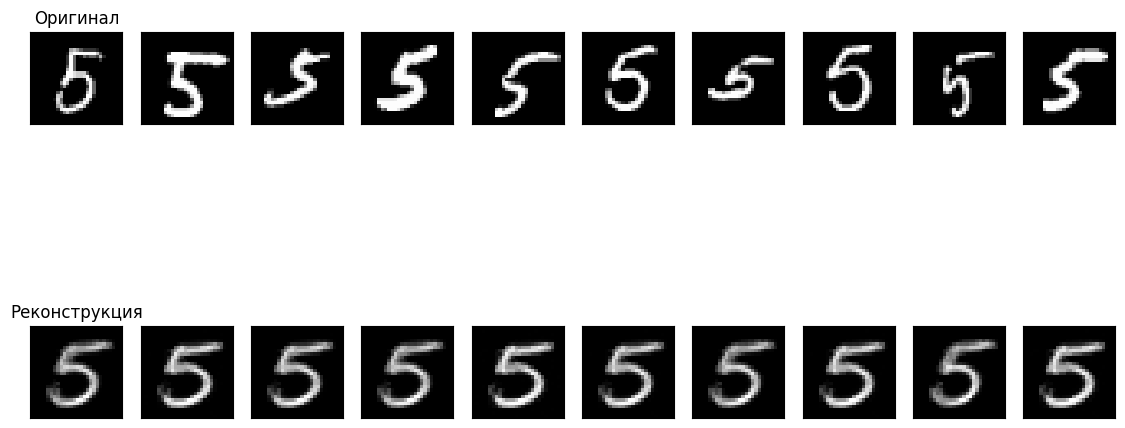

In [69]:
pred_test_fives = autoencoder.predict(X_test)

plot_images(X_test, pred_test_fives, n=10)
